# PRÉ-PROCESSAMENTO
Este arquivo dita o pré-processamento dos eletrodos. A idéia básica é:

 - recuperar todos os arquivos de uma pasta dos `alcoolicos` e dos `controles` de `dataset/small`.
 
 - abrir os arquivos e somar os valores de cada eletrodo em todos os arquivos.

 - normalizar os dados dividindo-os pela quantidade de arquivos da pasta, pois um eletrodo aparece uma vez a cada arquivo.

 - então, salvar os dados em `.json` para consulta com mais eficiência.

 - porfim, gerar os gráficos para análise.

# Importando as bibliotecas necessárias para o código

In [1]:
import os
import mne
import json
import numpy as np
import matplotlib.pyplot as plt
from mne import set_eeg_reference as car

# Recuperando os arquivos

Recuperando os nomes e abrindo cada um dos arquivos da pasta selecionada. Então, cada arquivo será passado para a função para processar os eletrodos dos arquivos.

In [2]:
def getSumElectodes(pathName):
    files = os.listdir(pathName)
    qtdElectrodes = len(files)
    resp = {}

    for file in files:
        processFile(open(pathName + file), resp, qtdElectrodes)

    return resp

# Recuperando os eletrodos

Abrindo o arquivo e processando cada uma das linhas. Estas, são quebradas para recuperar os valores necessários: `eletrodo`, `posição` e `valor`. Estes valores são adicionados em um objeto e somados.

In [6]:
def processFile(file, resp, qtdElectrodes):
    # para cada linha do arquivo
    for line in file.readlines():
        if line.startswith('#'):  #ignora as linhas iniciadas com #
            continue

        # 41 FP2 168 -4.720
        line = line.split()

        # recupera os valores da linha
        electrode, pos, value = line[1:4]
        insert(resp, electrode, int(pos), float(value), qtdElectrodes)

# Fazendo a média

Na posição específica de um eletrodo específico é somado com o valor atual dividido pela quantidade de arquivos na pasta. Assim a média é feita.

In [7]:
def insert(resp, electrode, pos, value, qtdElectrodes):
    try:
        resp[electrode][pos] += (value*(1/qtdElectrodes))
    except KeyError:
        resp[electrode] = [0]*256

        insert(resp, electrode, pos, value, qtdElectrodes)

# Salvando os dados

Com todos os dados dos eletrodos, bastas salvar esse objeto em `.json`. Salvar em um `.json` é apenas para visualizar algo que seja necessário.

In [5]:
def saveJson(output, name):
    # para o json é realmente muito fácil
    fileOutput = open(name, 'w')
    json.dump(output, fileOutput)
    fileOutput.close()

# Plotando os gráficos

Primeiramente os dados são adaptados para serem plotados. Através do gráfico, pode ser visualizado os eletrodos que não estão no padrão. Com isto, eles podem ser removidos usando o `car` e o gráfico plotado novamente.

In [10]:
def montaMatrizDoProfessor(electrodes):
    dataInput = []
    ch_types = ['eeg'] * 64
    ch_names = list(electrodes.keys())

    for electrode in ch_names:
        dataInput.append(electrodes[electrode])

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(dataInput, info)

    # São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
    raw.drop_channels(['X', 'nd', 'Y'])

    # Aplicamos a montagem do padrão 10-20 para todos os eletrodos
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)

    # Aqui mostramos todos os 61 eletrodos que representam dados EEG
    try:
        #raw.plot_psd()
        chs_P = ['CP5', 'C3', 'CP6', 'C4']
        inst, data = car(raw, ref_channels=chs_P)
        print(data.shape)
        print(inst)
        inst.plot_psd()
    except:
        pass

# Executando

É executado para os valores dos `alcoolicos` e após para os valores do `control`.

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
(256,)
<RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~277 kB, data loaded>
Effective window size : 1.000 (s)


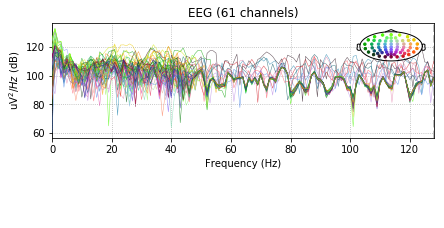

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
(256,)
<RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~277 kB, data loaded>
Effective window size : 1.000 (s)


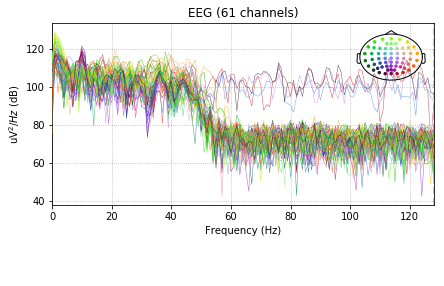

In [11]:
pathName = 'a_1_co2a0000364'
alcool = getSumElectodes('dataset/small/{}/'.format(pathName))
saveJson(alcool, 'dataset/small/{}.json'.format(pathName))
montaMatrizDoProfessor(alcool)

pathName = 'c_1_co2c0000337'
control = getSumElectodes('dataset/small/{}/'.format(pathName))
saveJson(control, 'dataset/small/{}.json'.format(pathName))
montaMatrizDoProfessor(control)